# 处理数据并构建模型预测
- 预测目标：2020年各区域5G市场规模、各区域无线整体市场规模

- 方法：趋势分解+ARIMA 
- 待解决：确定输出多少期、MSE等模型评估、234G数据的使用、其他三个地区5G预测都用logistic

## 1.数据预处理

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 

from statsmodels.graphics.tsaplots import plot_acf  #自相关图
from statsmodels.tsa.stattools import adfuller as ADF  #平稳性检测
from statsmodels.graphics.tsaplots import plot_pacf    #偏自相关图
from statsmodels.stats.diagnostic import acorr_ljungbox    #白噪声检验
from statsmodels.tsa.arima_model import ARIMA

from statsmodels.tsa.seasonal import seasonal_decompose

### Excel中的预处理
- 前8行没有数值，直接去除

- "3G北美规模"的Q404-Q305连续缺失，直接去掉前驱的Q403-Q104

- 添加各地区5G规模的列，赋值为(整体-2G-3G-4G)

- 填补缺失值
    - 前后有数值取：前后3个time step的均值
    - 前后无数值：改为NaN

- 修改异常值
    - 使得各地区满足(整体 == 2G+3G+4G+5G)
    - 同一地区、同一季度中，只修改一个值
    - 尽可能使得该值对于前后的变化幅度小

In [4]:
# 读取预处理后的数据
data = pd.read_csv('rowdata.csv',encoding='ANSI')
data.head()

,Unnamed: 0,单位：亿美元,2G北美规模,3G北美规模,4G北美规模,5G北美规模,北美整体规模,2G EMEA规模,3G EMEA规模,4G EMEA规模,...,2G亚太规模,3G亚太规模,4G亚太规模,5G亚太规模,亚太整体规模,2G CALA规模,3G CALA规模,4G CALA规模,5G CALA规模,CALA整体规模
0,8,Q101,20.49,0.0,0.0,0.0,20.49,32.41,0.0,0.0,...,25.48,2.06,0.0,0.0,27.53,4.07,0.0,0.0,0.0,4.07
1,9,Q201,23.83,0.0,0.0,0.0,23.83,36.97,0.0,0.0,...,30.73,2.21,0.0,0.0,32.95,7.80,0.0,0.0,0.0,7.80
2,10,Q301,23.07,0.0,0.0,0.0,23.07,29.22,0.0,0.0,...,25.42,2.22,0.0,0.0,27.64,6.19,0.0,0.0,0.0,6.19
3,11,Q401,22.18,0.0,0.0,0.0,22.18,30.50,0.0,0.0,...,23.71,2.07,0.0,0.0,25.78,4.36,0.0,0.0,0.0,4.36
4,12,Q102,21.59,0.0,0.0,0.0,21.59,24.67,0.0,0.0,...,21.92,2.15,0.0,0.0,24.07,5.17,0.0,0.0,0.0,5.17


In [5]:
# 格式化时间戳
# 2001.Q1 - 2019.Q4
data.index = pd.date_range('2001-01-01','2019-10-01',freq='QS')
data = data.iloc[:,1:]

data.head()

,单位：亿美元,2G北美规模,3G北美规模,4G北美规模,5G北美规模,北美整体规模,2G EMEA规模,3G EMEA规模,4G EMEA规模,5G EMEA规模,...,2G亚太规模,3G亚太规模,4G亚太规模,5G亚太规模,亚太整体规模,2G CALA规模,3G CALA规模,4G CALA规模,5G CALA规模,CALA整体规模
2001-01-01,Q101,20.49,0.0,0.0,0.0,20.49,32.41,0.0,0.0,0.0,...,25.48,2.06,0.0,0.0,27.53,4.07,0.0,0.0,0.0,4.07
2001-04-01,Q201,23.83,0.0,0.0,0.0,23.83,36.97,0.0,0.0,0.0,...,30.73,2.21,0.0,0.0,32.95,7.80,0.0,0.0,0.0,7.80
2001-07-01,Q301,23.07,0.0,0.0,0.0,23.07,29.22,0.0,0.0,0.0,...,25.42,2.22,0.0,0.0,27.64,6.19,0.0,0.0,0.0,6.19
2001-10-01,Q401,22.18,0.0,0.0,0.0,22.18,30.50,0.0,0.0,0.0,...,23.71,2.07,0.0,0.0,25.78,4.36,0.0,0.0,0.0,4.36
2002-01-01,Q102,21.59,0.0,0.0,0.0,21.59,24.67,0.0,0.0,0.0,...,21.92,2.15,0.0,0.0,24.07,5.17,0.0,0.0,0.0,5.17


C:\Users\85185\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


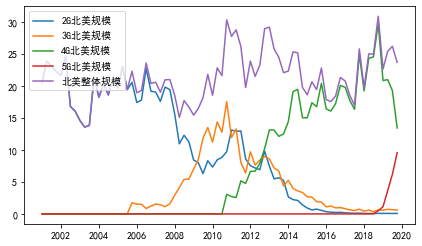

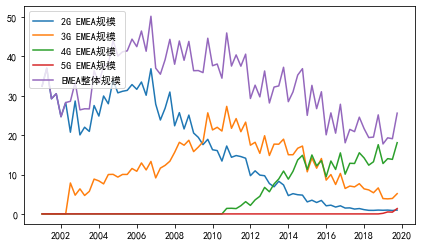

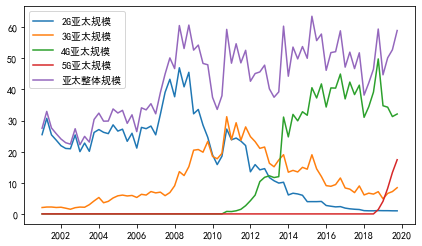

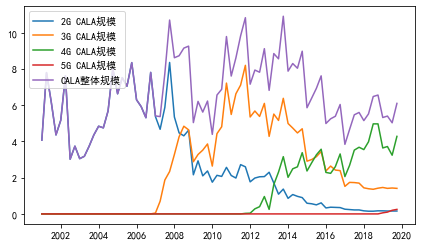

In [6]:
plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号

for i in range(4):
    plt.figure(figsize=(7,4))
    for cl in data.columns[5*i+1:5*i+6]:
        plt.plot(data[cl],label='%s'%cl)
        plt.legend(loc='upper left')
    plt.show()

## 2.预测建模

- 四个地区的整体规模
    - 平稳性检验、确定差分阶数
    - ARIMA对趋势项进行预测、添加季节项得到预测结果
    - 模型评估

- 四个地区的5G规模
    - ARIMA模型
    - logistic增长模型


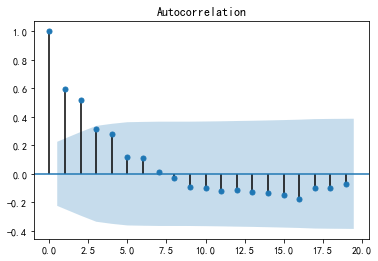

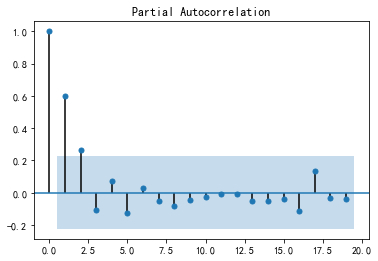

In [7]:
#AR2,MA3
a = plot_acf(data['北美整体规模'])
b = plot_pacf(data['北美整体规模'])

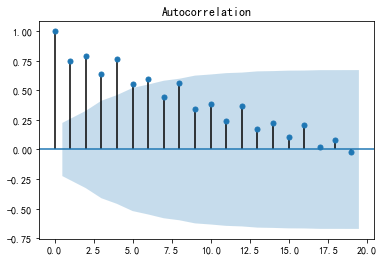

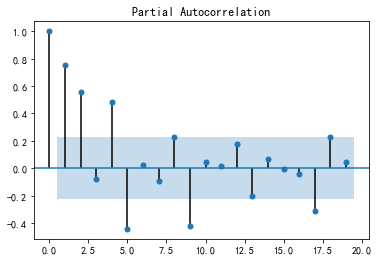

In [8]:
#AR拖尾，MA5
a = plot_acf(data['EMEA整体规模'])
b = plot_pacf(data['EMEA整体规模'])

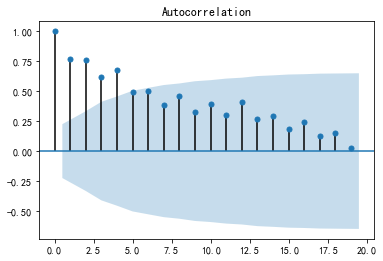

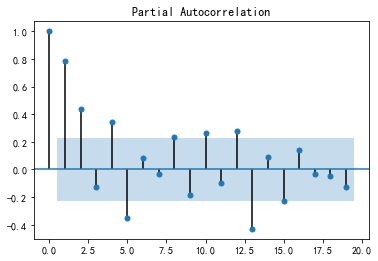

In [9]:
#AR拖尾，MA5
a = plot_acf(data['亚太整体规模'])
b = plot_pacf(data['亚太整体规模'])

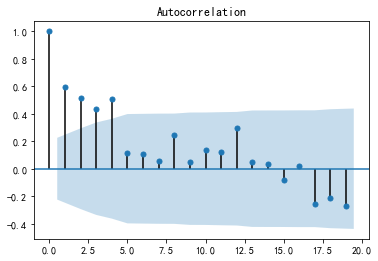

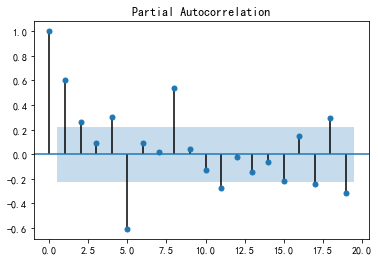

In [10]:
#AR拖尾，MA5
a = plot_acf(data['CALA整体规模'])
b = plot_pacf(data['CALA整体规模'])

## 2.1 四个地区的整体规模

北美整体规模


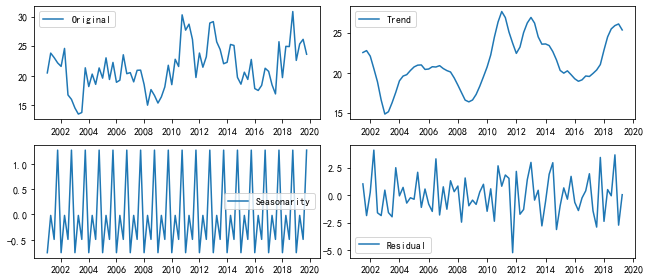

EMEA整体规模


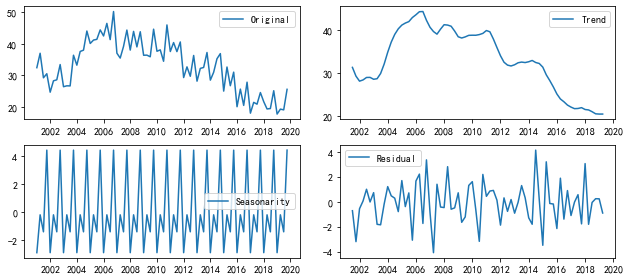

亚太整体规模


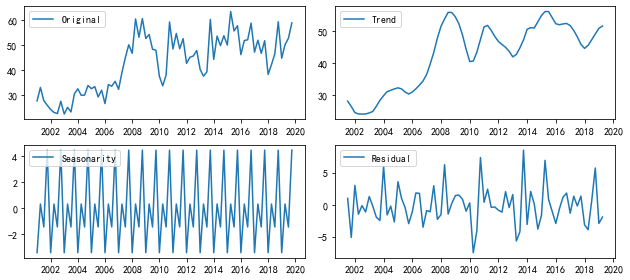

CALA整体规模


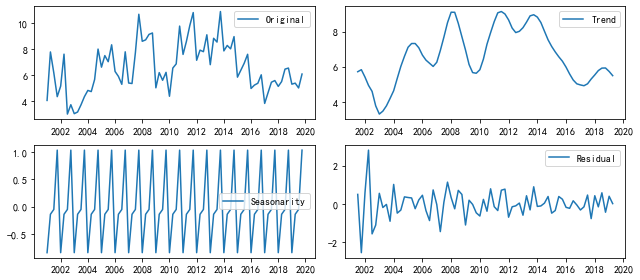

In [11]:
# 趋势分解
for i in range(4):
    name = data.columns[5*i+5]
    print(name)
    decomposition = seasonal_decompose(data[name])

    trend = decomposition.trend  # 趋势
    seasonal = decomposition.seasonal  # 季节性
    residual = decomposition.resid  # 剩余的

    # plt.title(name)   
    plt.figure(figsize=(9,4))
    plt.subplot(2,2,1)
    plt.plot(data[name],label='Original')
    plt.legend(loc='best')
    plt.subplot(2,2,2)
    plt.plot(trend,label='Trend')
    plt.legend(loc='best')
    plt.subplot(2,2,3)
    plt.plot(seasonal,label='Seasonarity')
    plt.legend(loc='best')
    plt.subplot(2,2,4)
    plt.plot(residual,label='Residual')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

In [12]:
# 平稳性检验：对四个地区整体规模 趋势项的一阶差分
# 四个地区整体规模的趋势项均有较大的起伏，可视为非平稳，故直接对其一阶差分进行平稳性检验
for i in range(4):
    name = data.columns[5*i+5]
    decomposition = seasonal_decompose(data[name])
    trend = decomposition.trend  # 趋势项
    ts = trend.diff(1).dropna()  # 一阶差分   
    pv = ADF(ts)[1]
    print('%s(趋势项的一阶差分) ADF p-value: %f'%(name,pv))

北美整体规模(趋势项的一阶差分) ADF p-value: 0.001132
EMEA整体规模(趋势项的一阶差分) ADF p-value: 0.159005
亚太整体规模(趋势项的一阶差分) ADF p-value: 0.382989
CALA整体规模(趋势项的一阶差分) ADF p-value: 0.000281


In [13]:
# 平稳性检验：对EMEA整体规模、亚太整体规模 趋势项的二阶差分
for i in range(2):
    name = data.columns[5*i+10]
    decomposition = seasonal_decompose(data[name])
    trend = decomposition.trend  # 趋势项
    ts = trend.diff(1).diff(1).dropna()  # 二阶差分   
    pv = ADF(ts)[1]
    print('%s(趋势项的二阶差分) ADF p-value: %f'%(name,pv))

EMEA整体规模(趋势项的二阶差分) ADF p-value: 0.000257
亚太整体规模(趋势项的二阶差分) ADF p-value: 0.001156


C:\Users\85185\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\85185\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\85185\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\85185\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\85185\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:695: RuntimeWarning: inva

6 5


C:\Users\85185\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


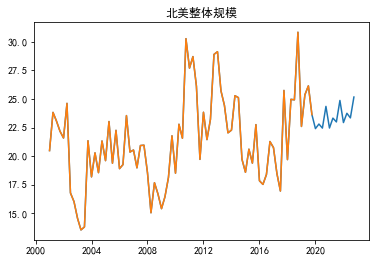

北美整体规模预测
 2020-01-01    22.410879
2020-04-01    22.810337
2020-07-01    22.457348
2020-10-01    24.354271
2021-01-01    22.463028
2021-04-01    23.329263
2021-07-01    22.996123
2021-10-01    24.873004
2022-01-01    22.940015
2022-04-01    23.753842
2022-07-01    23.348548
2022-10-01    25.172670
Freq: QS-JAN, dtype: float64


C:\Users\85185\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py:1441: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(-inv(hess)))
C:\Users\85185\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\85185\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\85185\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
const,0.052333,0.037394,1.399502,1.668986e-01,-0.020958,0.125624
ar.L1.D.北美整体规模,0.512929,0.190694,2.689798,9.282751e-03,0.139175,0.886683
ar.L2.D.北美整体规模,0.224638,0.235876,0.952356,3.448017e-01,-0.237670,0.686946
ar.L3.D.北美整体规模,-0.114868,0.215328,-0.533454,5.957236e-01,-0.536903,0.307168
ar.L4.D.北美整体规模,0.075909,0.201170,0.377336,7.072775e-01,-0.318377,0.470194
ar.L5.D.北美整体规模,-0.061172,0.203512,-0.300582,7.647902e-01,-0.460049,0.337705
ar.L6.D.北美整体规模,-0.012932,0.158895,-0.081390,9.354072e-01,-0.324360,0.298495
ma.L1.D.北美整体规模,0.967042,NaN,NaN,NaN,NaN,NaN
ma.L2.D.北美整体规模,-0.032858,0.122718,-0.267757,7.898205e-01,-0.273381,0.207664
ma.L3.D.北美整体规模,0.033260,0.123320,0.269709,7.883251e-01,-0.208442,0.274963


In [14]:
# 北美整体规模：超参数优化
# ARIMA(p,1,q)

ts = data['北美整体规模'] # 原始数据

ts_t = seasonal_decompose(ts).trend.dropna() # 趋势项
ts_s = seasonal_decompose(ts).seasonal

pmax = int(ts_t.size/10)+1 # 一般阶数不超过length/10
qmax = int(ts_t.size/10)+1 

aic = np.zeros([pmax,qmax]) # aic矩阵，用以网格搜索p,q的值
for p in range(pmax):
    for q in range(qmax):
        try:
            v = ARIMA(ts_t, (p,1,q)).fit().aic
            aic[p,q] = v
        except:
            pass

aic = np.nan_to_num(aic)
aic[aic==0] = 10e5

arg = np.where(aic==np.min(aic)) # aic矩阵最小值处
p_arg = arg[0][0]
q_arg = arg[1][0]
print(p_arg,q_arg)
md1 = ARIMA(ts_t, (p_arg,1,q_arg)).fit()
 

# 外推预测
pre = md1.forecast(6+8) # 预测结果、标准误差、置信区间
season_part = ts_s.iloc[2:8+8].values
join = pd.Series(pre[0]+season_part, index=pd.date_range('2019-07-01','2022-10-01',freq='QS')).iloc[2:]
result = ts.append(join)

plt.plot(result)
plt.plot(ts)
plt.title('北美整体规模')
plt.show()

print('北美整体规模预测\n',join)
md1.summary2().tables[1]

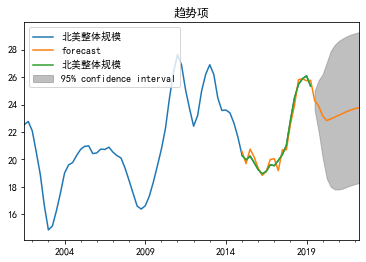

In [15]:
fig, ax = plt.subplots()
ax = ts_t.plot(ax=ax)
md1.plot_predict(start='2015-01-01', end='2022-04-01', dynamic=False, ax=ax)
plt.legend(loc='upper left')
plt.title('趋势项')
plt.show()

C:\Users\85185\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\85185\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\85185\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\85185\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\85185\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: Convergence

2 6


C:\Users\85185\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\85185\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


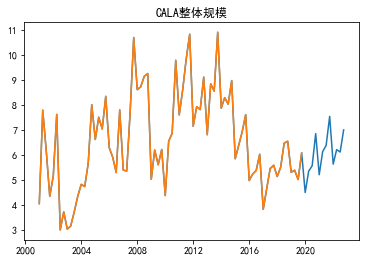

CALA整体规模预测
 2020-01-01    4.511891
2020-04-01    5.367052
2020-07-01    5.578611
2020-10-01    6.863055
2021-01-01    5.222438
2021-04-01    6.145259
2021-07-01    6.395567
2021-10-01    7.551368
2022-01-01    5.645002
2022-04-01    6.224372
2022-07-01    6.128790
2022-10-01    7.010914
Freq: QS-JAN, dtype: float64


,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
const,0.010923,0.055370,0.197273,8.442590e-01,-0.097601,0.119447
ar.L1.D.CALA整体规模,1.769136,0.015904,111.240592,4.301070e-73,1.737965,1.800307
ar.L2.D.CALA整体规模,-0.984851,0.016307,-60.394620,8.372725e-57,-1.016812,-0.952890
ma.L1.D.CALA整体规模,-0.284056,0.146824,-1.934661,5.759781e-02,-0.571826,0.003715
ma.L2.D.CALA整体规模,-0.891364,0.144046,-6.188061,5.340247e-08,-1.173688,-0.609039
ma.L3.D.CALA整体规模,0.944766,0.158995,5.942124,1.394234e-07,0.633142,1.256389
ma.L4.D.CALA整体规模,-0.339446,0.164015,-2.069602,4.266318e-02,-0.660910,-0.017982
ma.L5.D.CALA整体规模,-0.308228,0.132379,-2.328379,2.316826e-02,-0.567685,-0.048770
ma.L6.D.CALA整体规模,0.784701,0.131305,5.976175,1.221371e-07,0.527348,1.042054


In [17]:
# CALA整体规模：超参数优化
# ARIMA(p,1,q)

ts = data['CALA整体规模'] # 原始数据

ts_t = seasonal_decompose(ts).trend.dropna() # 趋势项
ts_s = seasonal_decompose(ts).seasonal

pmax = int(ts_t.size/10)+1 # 一般阶数不超过length/10
qmax = int(ts_t.size/10)+1 

aic = np.zeros([pmax,qmax]) # aic矩阵，用以网格搜索p,q的值
for p in range(pmax):
    for q in range(qmax):
        try:
            v = ARIMA(ts_t, (p,1,q)).fit().aic
            aic[p,q] = v
        except:
            pass

aic = np.nan_to_num(aic)
aic[aic==0] = 10e5

arg = np.where(aic==np.min(aic)) # aic矩阵最小值处
p_arg = arg[0][0]
q_arg = arg[1][0]
print(p_arg,q_arg)
md2 = ARIMA(ts_t, (p_arg,1,q_arg)).fit()


# 外推预测
pre = md2.forecast(6+8) # 预测结果、标准误差、置信区间
season_part = ts_s.iloc[2:8+8].values
join = pd.Series(pre[0]+season_part, index=pd.date_range('2019-07-01','2022-10-01',freq='QS')).iloc[2:]
result = ts.append(join)

plt.plot(result)
plt.plot(ts)
plt.title('CALA整体规模')
plt.show()

print('CALA整体规模预测\n', join)
md2.summary2().tables[1] 

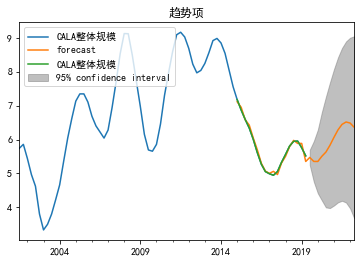

In [18]:
fig, ax = plt.subplots()
ax = ts_t.plot(ax=ax)
md2.plot_predict(start='2015-01-01', end='2022-04-01', dynamic=False, ax=ax)
plt.legend(loc='upper left')
plt.title('趋势项')
plt.show()

C:\Users\85185\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\85185\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\85185\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\85185\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\85185\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInve

4 5


C:\Users\85185\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


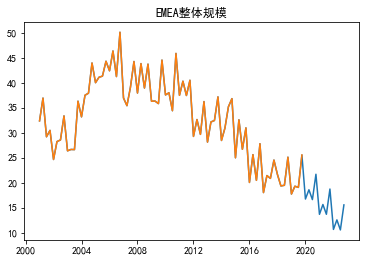

EMEA整体规模预测
 2020-01-01    16.748456
2020-04-01    18.603819
2020-07-01    16.634339
2020-10-01    21.711034
2021-01-01    13.681304
2021-04-01    15.653122
2021-07-01    13.691226
2021-10-01    18.750264
2022-01-01    10.661357
2022-04-01    12.571074
2022-07-01    10.560400
2022-10-01    15.572304
Freq: QS-JAN, dtype: float64


,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
const,-0.011763,0.010775,-1.091728,2.793171e-01,-0.032881,0.009355
ar.L1.D2.EMEA整体规模,-0.223736,0.126475,-1.769008,8.197485e-02,-0.471623,0.024151
ar.L2.D2.EMEA整体规模,-0.068924,0.133712,-0.515467,6.081211e-01,-0.330994,0.193146
ar.L3.D2.EMEA整体规模,-0.060267,0.143266,-0.420665,6.755024e-01,-0.341064,0.220530
ar.L4.D2.EMEA整体规模,-0.076107,0.132878,-0.572757,5.689492e-01,-0.336543,0.184329
ma.L1.D2.EMEA整体规模,0.915044,0.105301,8.689775,3.294723e-12,0.708657,1.121430
ma.L2.D2.EMEA整体规模,-0.056452,0.120956,-0.466714,6.423951e-01,-0.293521,0.180618
ma.L3.D2.EMEA整体规模,0.056452,0.122215,0.461906,6.458195e-01,-0.183085,0.295989
ma.L4.D2.EMEA整体规模,-0.915044,0.120383,-7.601093,2.352188e-10,-1.150990,-0.679097
ma.L5.D2.EMEA整体规模,-1.000000,0.123353,-8.106803,3.221850e-11,-1.241768,-0.758232


In [19]:
# EMEA整体规模：超参数优化
# ARIMA(p,2,q)

ts = data['EMEA整体规模'] # 原始数据

ts_t = seasonal_decompose(ts).trend.dropna() # 趋势项
ts_s = seasonal_decompose(ts).seasonal

pmax = int(ts_t.size/10)+1 # 一般阶数不超过length/10
qmax = int(ts_t.size/10)+1 

aic = np.zeros([pmax,qmax]) # aic矩阵，用以网格搜索p,q的值
for p in range(pmax):
    for q in range(qmax):
        try:
            v = ARIMA(ts_t, (p,2,q)).fit().aic
            aic[p,q] = v
        except:
            pass

aic = np.nan_to_num(aic)
aic[aic==0] = 10e5

arg = np.where(aic==np.min(aic)) # aic矩阵最小值处
p_arg = arg[0][0]
q_arg = arg[1][0]
print(p_arg,q_arg)
md3 = ARIMA(ts_t, (p_arg,2,q_arg)).fit()


# 外推预测
pre = md3.forecast(7+8) # 预测结果、标准误差、置信区间
season_part = ts_s.iloc[1:8+8].values
join = pd.Series(pre[0]+season_part, index=pd.date_range('2019-04-01','2022-10-01',freq='QS')).iloc[3:]
result = ts.append(join)

plt.plot(result)
plt.plot(ts)
plt.title('EMEA整体规模')
plt.show()

print('EMEA整体规模预测\n',join)
md3.summary2().tables[1] 

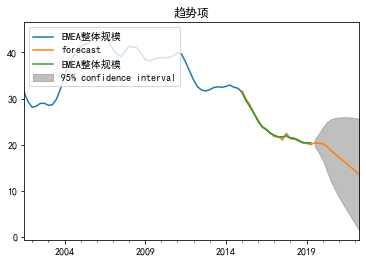

In [20]:
fig, ax = plt.subplots()
ax = ts_t.plot(ax=ax)
md3.plot_predict(start='2015-01-01', end='2022-04-01', dynamic=False, ax=ax)
plt.legend(loc='upper left')
plt.title('趋势项')
plt.show()

C:\Users\85185\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\85185\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\85185\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\85185\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\85185\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarnin

6 2


C:\Users\85185\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


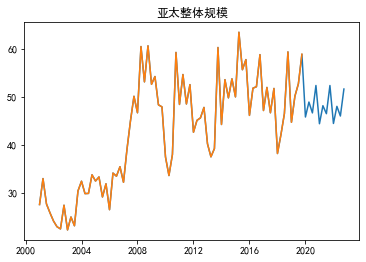

亚太整体规模预测
 2020-01-01    45.822199
2020-04-01    48.948727
2020-07-01    46.679138
2020-10-01    52.410645
2021-01-01    44.416131
2021-04-01    48.187625
2021-07-01    46.514570
2021-10-01    52.403806
2022-01-01    44.473615
2022-04-01    48.049385
2022-07-01    46.030056
2022-10-01    51.668743
Freq: QS-JAN, dtype: float64


,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
const,-1.117918e-02,0.014090,-7.934164e-01,4.306107e-01,-0.038795,0.016437
ar.L1.D2.亚太整体规模,7.980371e-01,0.113984,7.001304e+00,2.305315e-09,0.574632,1.021442
ar.L2.D2.亚太整体规模,-1.248049e-01,0.139619,-8.938985e-01,3.748895e-01,-0.398452,0.148843
ar.L3.D2.亚太整体规模,1.402734e-02,0.126791,1.106333e-01,9.122703e-01,-0.234479,0.262534
ar.L4.D2.亚太整体规模,-4.678994e-01,0.123908,-3.776179e+00,3.634281e-04,-0.710755,-0.225044
ar.L5.D2.亚太整体规模,4.586383e-01,0.136921,3.349646e+00,1.391780e-03,0.190277,0.726999
ar.L6.D2.亚太整体规模,-2.681412e-01,0.114758,-2.336589e+00,2.276159e-02,-0.493062,-0.043221
ma.L1.D2.亚太整体规模,3.087798e-08,0.058927,5.240064e-07,9.999996e-01,-0.115494,0.115494
ma.L2.D2.亚太整体规模,-1.000000e+00,0.058927,-1.697023e+01,8.802014e-25,-1.115494,-0.884506


In [21]:
# 亚太整体规模：超参数优化
# ARIMA(p,2,q)

ts = data['亚太整体规模'] # 原始数据

ts_t = seasonal_decompose(ts).trend.dropna() # 趋势项
ts_s = seasonal_decompose(ts).seasonal

pmax = int(ts_t.size/10)+1 # 一般阶数不超过length/10
qmax = int(ts_t.size/10)+1 

aic = np.zeros([pmax,qmax]) # aic矩阵，用以网格搜索p,q的值
for p in range(pmax):
    for q in range(qmax):
        try:
            v = ARIMA(ts_t, (p,2,q)).fit().aic
            aic[p,q] = v
        except:
            pass

aic = np.nan_to_num(aic)
aic[aic==0] = 10e5

arg = np.where(aic==np.min(aic)) # aic矩阵最小值处
p_arg = arg[0][0]
q_arg = arg[1][0]
print(p_arg,q_arg)
md4 = ARIMA(ts_t, (p_arg,2,q_arg)).fit()


# 外推预测
pre = md4.forecast(7+8) # 预测结果、标准误差、置信区间
season_part = ts_s.iloc[1:8+8].values
join = pd.Series(pre[0]+season_part, index=pd.date_range('2019-04-01','2022-10-01',freq='QS')).iloc[3:]
result = ts.append(join)

plt.plot(result)
plt.plot(ts)
plt.title('亚太整体规模')
plt.show()

print('亚太整体规模预测\n',join)
md4.summary2().tables[1] 

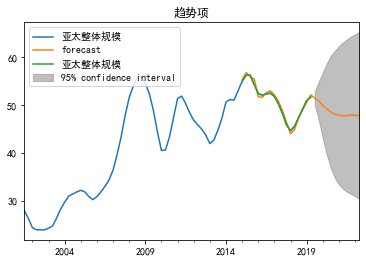

In [22]:
fig, ax = plt.subplots()
ax = ts_t.plot(ax=ax)
md4.plot_predict(start='2015-01-01', end='2022-04-01', dynamic=False, ax=ax)
plt.legend(loc='upper left')
plt.title('趋势项')
plt.show()

## 2.2 四个地区的5G规模

### 2.2.1 ARIMA模型

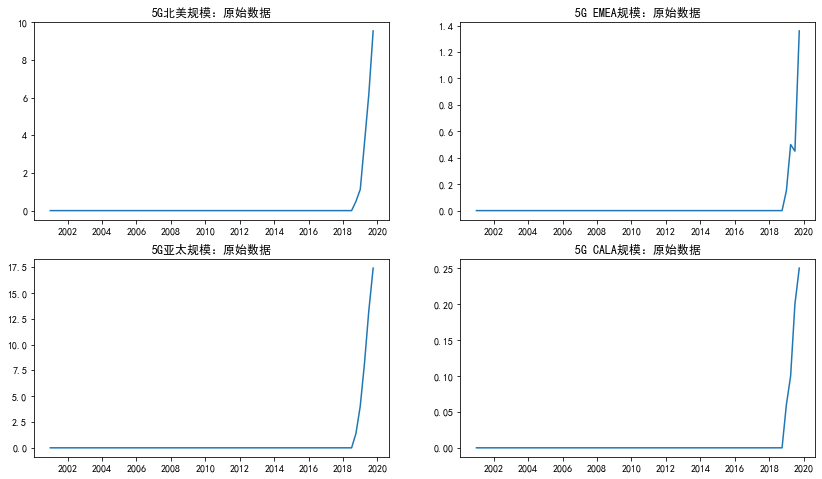

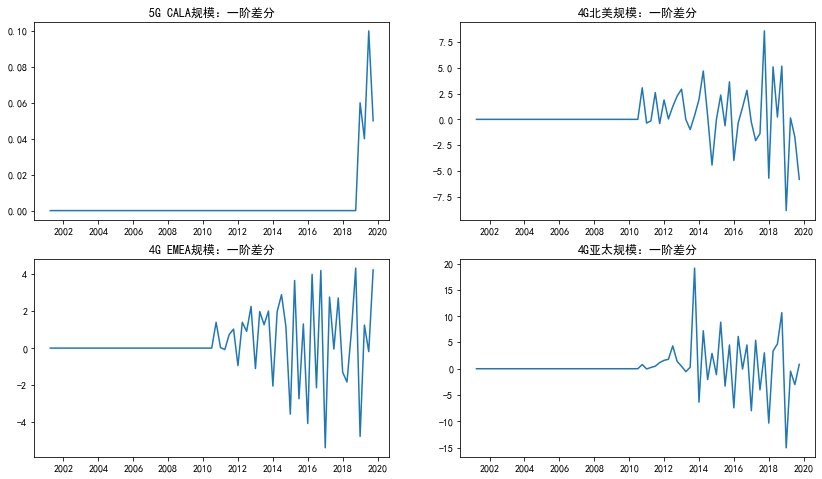

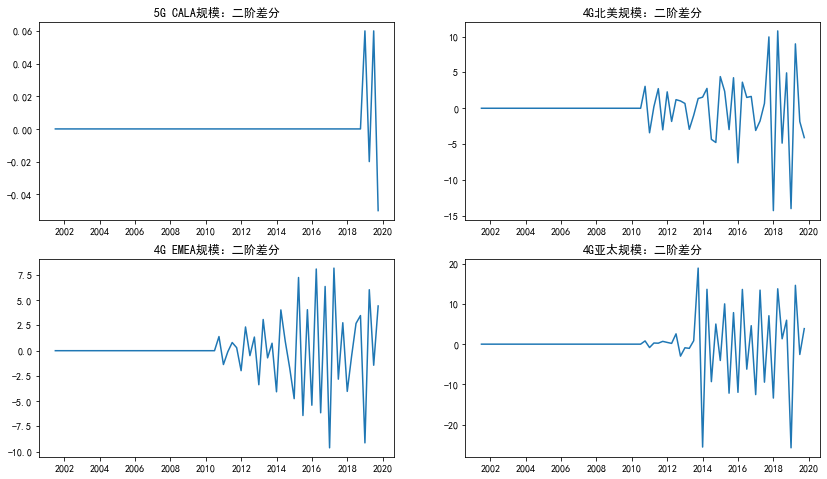

In [54]:
# 平稳性检验：对四个地区5G规模
    # 观测值均过少，且较为平滑，故跳过趋势分解和单位根检验
    # 直接根据时序图，CALA、亚太、EMEA定为1阶差分，北美定位2阶差分

plt.figure(figsize=(14,8))

for i in range(4):
    name = data.columns[5*i+4]
    plt.subplot(2,2,i+1)
    plt.title('%s：原始数据'%name)
    plt.plot(data[name],label=name)
 
plt.figure(figsize=(14,8))
for i in range(4):
    name = data.columns[5*i-2]
    plt.subplot(2,2,i+1)
    plt.title('%s：一阶差分'%name)
    plt.plot(data[name].diff(),label=name)

plt.figure(figsize=(14,8))
for i in range(4):
    name = data.columns[5*i-2]
    plt.subplot(2,2,i+1)
    plt.title('%s：二阶差分'%name)
    plt.plot(data[name].diff().diff(),label=name)

C:\Users\85185\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\85185\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
C:\Users\85185\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:221: RuntimeWarning: divide by zero encountered in true_divide
  Z_mat, R_mat, T_mat)
C:\Users\85185\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
C:\Users\85185\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:669: RuntimeWarning: invalid value encountered in tr

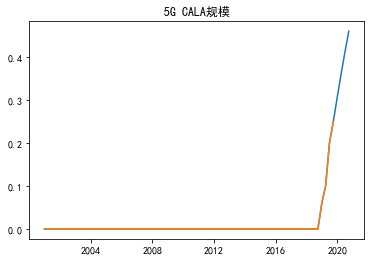

5G CALA规模预测
 2020-01-01    0.306026
2020-04-01    0.359624
2020-07-01    0.410927
2020-10-01    0.460058
Freq: QS-JAN, dtype: float64


,Coef.,Std.Err.,t,P>|t|,[0.025,0.975]
const,0.011587,0.013693,0.846197,4.002464e-01,-0.015251,0.038425
ar.L1.D.5G CALA规模,0.945352,0.060582,15.604458,8.439842e-25,0.826613,1.064091
ma.L1.D.5G CALA规模,-0.350822,0.105389,-3.328815,1.377013e-03,-0.557381,-0.144262


In [55]:
# CALA 5G规模：超参数优化
# ARIMA(p,1,q) p,q∈[0,1]

ts = data['5G CALA规模'].dropna()  # 原始数据

# aic矩阵，用以网格搜索p,q的值，观测过少，搜索范围定为[0,1]即可
aic = np.zeros([2,2]) 
for p in range(pmax):
    for q in range(qmax):
        try:
            v = ARIMA(ts, (p,1,q)).fit().aic
            aic[p,q] = v
        except:
            pass

aic = np.nan_to_num(aic)
aic[aic==0] = 10e5

arg = np.where(aic==np.min(aic)) # aic矩阵最小值处
p_arg = arg[0][0]
q_arg = arg[1][0]

md = ARIMA(ts, (p_arg,1,q_arg)).fit()

# 外推预测
pre = md.forecast(4) # 预测结果、标准误差、置信区间
join = pd.Series(pre[0], index=pd.date_range('2020-01-01','2020-10-01',freq='QS'))
result = ts.append(join)

plt.plot(result)
plt.plot(ts)
plt.title('5G CALA规模')
plt.show()

print('5G CALA规模预测\n', join)
md.summary2().tables[1] 

In [ ]:
# 5G北美规模：超参数优化
# ARIMA(p,2,q) p,q∈[0,1]

ts = data['5G北美规模'].dropna()  # 原始数据

# aic矩阵，用以网格搜索p,q的值，观测过少，搜索范围定为[0,1]即可
aic = np.zeros([2,2]) 
for p in range(pmax):
    for q in range(qmax):
        try:
            v = ARIMA(ts, (p,2,q)).fit().aic
            aic[p,q] = v
        except:
            pass

aic = np.nan_to_num(aic)
aic[aic==0] = 10e5

arg = np.where(aic==np.min(aic)) # aic矩阵最小值处
p_arg = arg[0][0]
q_arg = arg[1][0]

md = ARIMA(ts, (p_arg,2,q_arg)).fit()

# 外推预测
pre = md.forecast(4) # 预测结果、标准误差、置信区间
join = pd.Series(pre[0], index=pd.date_range('2020-01-01','2020-10-01',freq='QS'))
result = ts.append(join)

plt.plot(result)
plt.plot(ts)
plt.title('5G北美规模')
plt.show()

print('5G北美规模预测\n', join)
md.summary2().tables[1] 

In [ ]:
# CALA 5G规模：超参数优化
# ARIMA(p,1,q) p,q∈[0,1]

ts = data['5G EMEA规模'].dropna()  # 原始数据

# aic矩阵，用以网格搜索p,q的值，观测过少，搜索范围定为[0,1]即可
aic = np.zeros([2,2]) 
for p in range(pmax):
    for q in range(qmax):
        try:
            v = ARIMA(ts, (p,1,q)).fit().aic
            aic[p,q] = v
        except:
            pass

aic = np.nan_to_num(aic)
aic[aic==0] = 10e5

arg = np.where(aic==np.min(aic)) # aic矩阵最小值处
p_arg = arg[0][0]
q_arg = arg[1][0]

md = ARIMA(ts, (p_arg,1,q_arg)).fit()

# 外推预测
pre = md.forecast(4) # 预测结果、标准误差、置信区间
join = pd.Series(pre[0], index=pd.date_range('2020-01-01','2020-10-01',freq='QS'))
result = ts.append(join)

plt.plot(result)
plt.plot(ts)
plt.title('5G EMEA规模')
plt.show()

print('5G EMEA规模预测\n', join)
md.summary2().tables[1] 

In [ ]:
# CALA 5G规模：超参数优化
# ARIMA(p,1,q) p,q∈[0,1]

ts = data['5G亚太规模'].dropna()  # 原始数据

# aic矩阵，用以网格搜索p,q的值，观测过少，搜索范围定为[0,1]即可
aic = np.zeros([2,2]) 
for p in range(pmax):
    for q in range(qmax):
        try:
            v = ARIMA(ts, (p,1,q)).fit().aic
            aic[p,q] = v
        except:
            pass

aic = np.nan_to_num(aic)
aic[aic==0] = 10e5

arg = np.where(aic==np.min(aic)) # aic矩阵最小值处
p_arg = arg[0][0]
q_arg = arg[1][0]

md = ARIMA(ts, (p_arg,1,q_arg)).fit()

# 外推预测
pre = md.forecast(4) # 预测结果、标准误差、置信区间
join = pd.Series(pre[0], index=pd.date_range('2020-01-01','2020-10-01',freq='QS'))
result = ts.append(join)

plt.plot(result)
plt.plot(ts)
plt.title('5G亚太规模')
plt.show()

print('5G亚太规模\n', join)
md.summary2().tables[1] 

### 2.2.2 logistic增长模型

- 通过ARIMA模型预测的北美5G规模在2020的3、4季度都超过了北美地区整体规模，不符合实际情况

- 观察各地区2、3、4G数据，它们在出现后均呈增速先增后减的趋势

- 因此尝试采用logistic增长模型对北美地区5G规模进行预测


In [12]:
from scipy.optimize import curve_fit

In [86]:
def logitpre(t,P,name,th):
    def logistic_increase_function(t,P0,r):
        '''
        t:time   
        t0:initial time    
        P0:initial_value    
        K:capacity  
        r:increase_rate
        '''
        exp_value=np.exp(r*(t-75))
        return (th*exp_value*P0)/(th+(exp_value-1)*P0)

    # 用最小二乘法估计拟合
    popt, pcov = curve_fit(logistic_increase_function, t, P)

    #拟合后预测的P值
    P_predict = logistic_increase_function(t,popt[0],popt[1])
    #未来预测
    future=[71,72,73,74,75,76,77,78,79,80,81,82]
    future=np.array(future)
    future_predict=logistic_increase_function(future,popt[0],popt[1])
    #近期情况预测
    tomorrow=[75,76,77,78,79,80,81,82]
    tomorrow=np.array(tomorrow)
    tomorrow_predict=logistic_increase_function(tomorrow,popt[0],popt[1])
    np.insert(tomorrow_predict,0,P[-1])

    #绘图
    plot1 = plt.plot(t, P, 's',label="历史数据")
    plot2 = plt.plot(t, P_predict, 'r')
    plot3 = plt.plot(tomorrow, tomorrow_predict, 'b')
    plot3 = plt.plot(tomorrow, tomorrow_predict, 's',label='预测数据')
    plt.xlabel('季度')
#     if len(t) == 5:
#         plt.xticks(np.append(t[0:4],tomorrow),['18-4','19-1','19-2','19-3','19-4','20-1','20-2','20-3','20-4','21-1','21-2','21-3']) 
#     elif len(t) == 4:
#         plt.xticks(np.append(t[0:3],tomorrow),['19-1','19-2','19-3','19-4','20-1','20-2','20-3','20-4','21-1','21-2','21-3'])
    if len(t) == 5:
        plt.xticks(np.append(t[0:4],tomorrow)[1:13:2],['2019-01','2019-07','2020-01','2020-07','2021-01','2021-07']) 
    elif len(t) == 4:
        plt.xticks(np.append(t[0:3],tomorrow)[0:12:2],['2019-01','2019-07','2020-01','2020-07','2021-01','2021-07'])    
    plt.legend(loc=0) #指定legend的位置右下角
    plt.show()

    # print(tomorrow_predict)
    result = pd.Series(tomorrow_predict, index=pd.date_range('2020-01-01','2021-10-01',freq='QS'))
    print('5G'+name+'规模\n', result.iloc[:4])

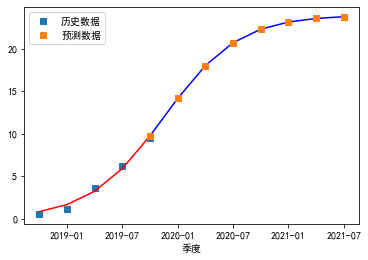

5G北美规模
 2020-01-01     9.768197
2020-04-01    14.176402
2020-07-01    18.050784
2020-10-01    20.747687
Freq: QS-JAN, dtype: float64


In [87]:
t = np.array([71,72,73,74,75])
P = data['5G北美规模'][71:76].values
logitpre(t,P,'北美',24)

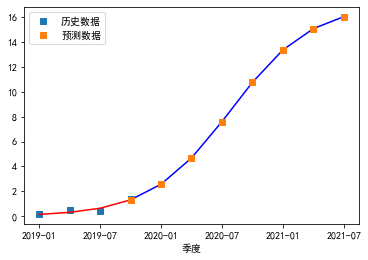

5G欧洲规模
 2020-01-01    1.310880
2020-04-01    2.569025
2020-07-01    4.674893
2020-10-01    7.598100
Freq: QS-JAN, dtype: float64


In [88]:
t = np.array([72,73,74,75])
P = data['5G EMEA规模'][72:76].values
logitpre(t,P,'欧洲',17)

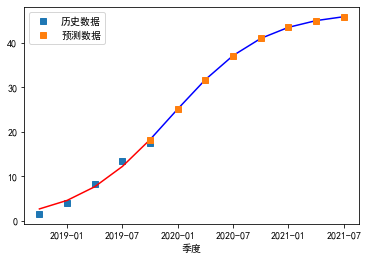

5G亚太规模
 2020-01-01    18.226330
2020-04-01    25.108241
2020-07-01    31.723738
2020-10-01    37.126249
Freq: QS-JAN, dtype: float64


In [89]:
t = np.array([71,72,73,74,75])
P = data['5G亚太规模'][71:76].values
logitpre(t,P,'亚太',47)

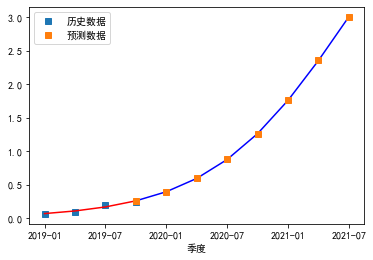

5G CALA规模
 2020-01-01    0.261385
2020-04-01    0.396983
2020-07-01    0.595623
2020-10-01    0.878081
Freq: QS-JAN, dtype: float64


In [90]:
t = np.array([72,73,74,75])
P = data['5G CALA规模'][72:76].values
logitpre(t,P,' CALA',6)